In [1]:
# Import libraries:
import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo, structures
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
from detectron2.engine import DefaultTrainer
# load model
cfg = get_cfg()
cfg.OUTPUT_DIR = "./Models"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[04/23 10:47:00 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./Models/model_final.pth ...


In [128]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os
import torch
from torchvision import models, transforms
from PIL import Image


# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=6, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=6, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Initialize the model
model = CNN()
model.load_state_dict(torch.load('best_model_weights.pth'))


# Load and preprocess the unseen image
#image_path = './output/test/detached/Img041979_bt83-15W_mask_8.png'  # Replace with the path to your image
#image = Image.open(image_path)
transform = transforms.Compose([
        #transforms.Resize(256),
        transforms.Resize((480,640)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

'''
input_tensor = transform(Image.fromarray(combined_image)).unsqueeze(0)

model.eval()
with torch.no_grad():
    outputs=model(input_tensor)
    
_, predicted=torch.max(outputs,1)

print(predicted.item())
'''

0


In [16]:
import matplotlib.pyplot as plt
mask=outputs['instances'].pred_masks[0].cpu()

In [110]:
outputs['instances'].pred_boxes[0]

Boxes(tensor([[345.7756, 208.7732, 469.3676, 310.4487]], device='cuda:0'))

1
The predicted class is: detached


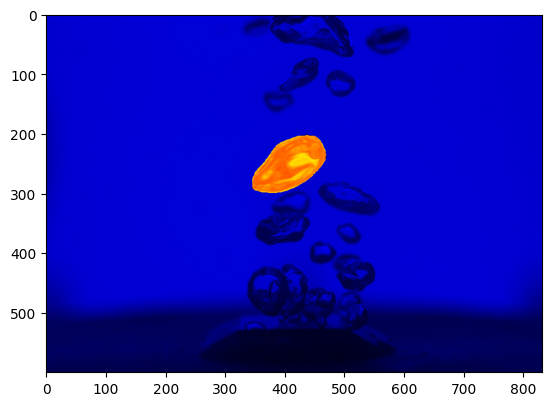

1
The predicted class is: detached


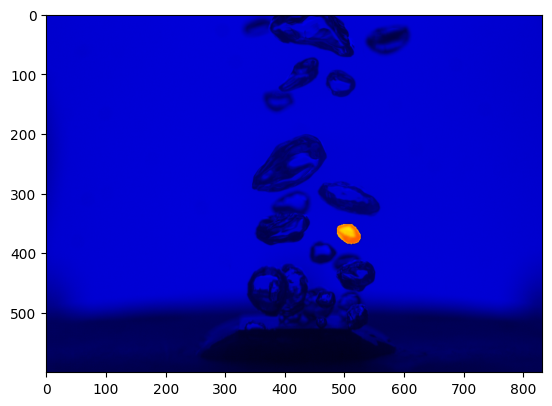

1
The predicted class is: detached


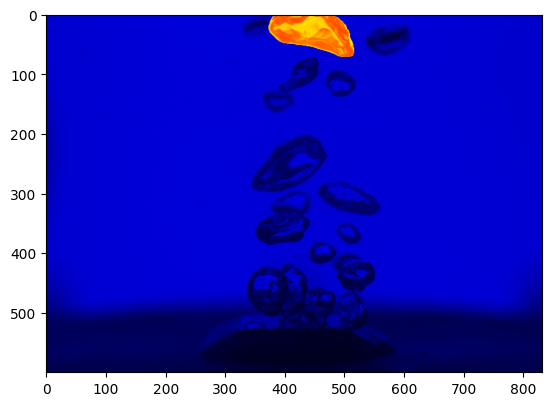

1
The predicted class is: detached


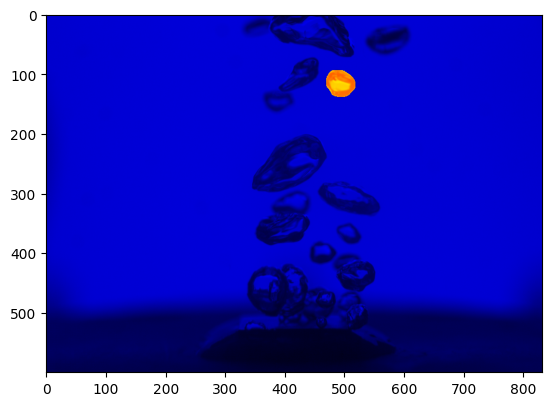

1
The predicted class is: detached


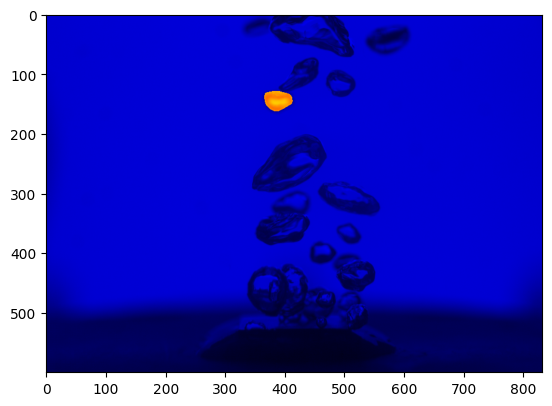

1
The predicted class is: detached


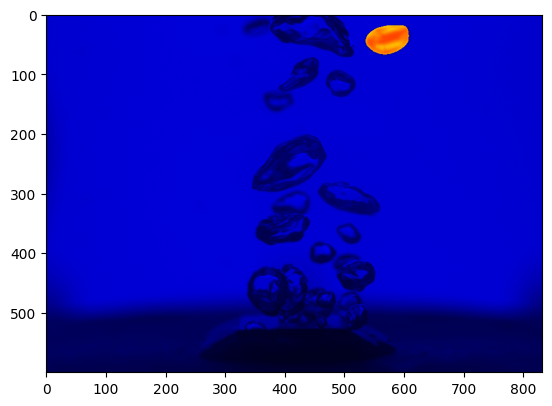

1
The predicted class is: detached


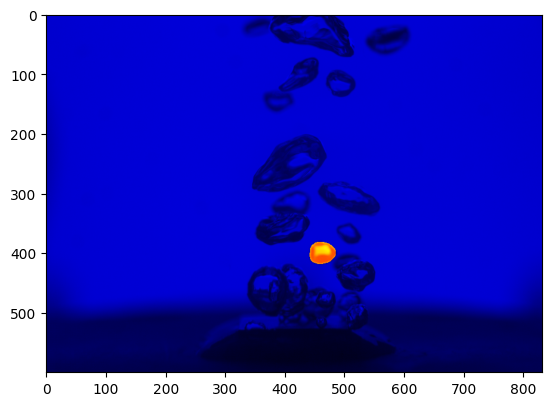

1
The predicted class is: detached


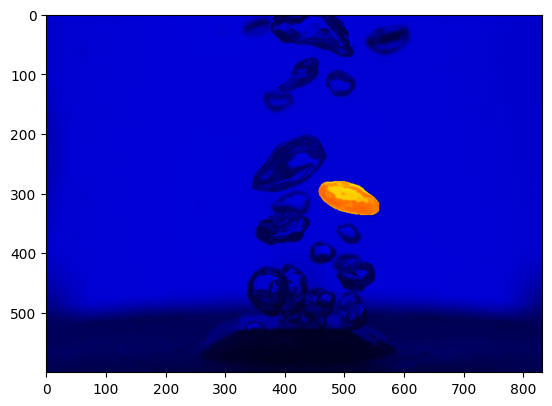

1
The predicted class is: detached


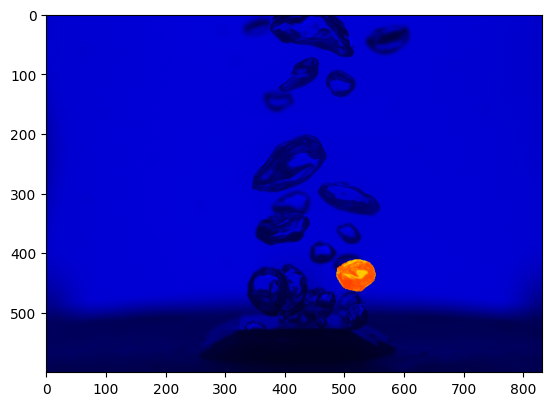

1
The predicted class is: detached


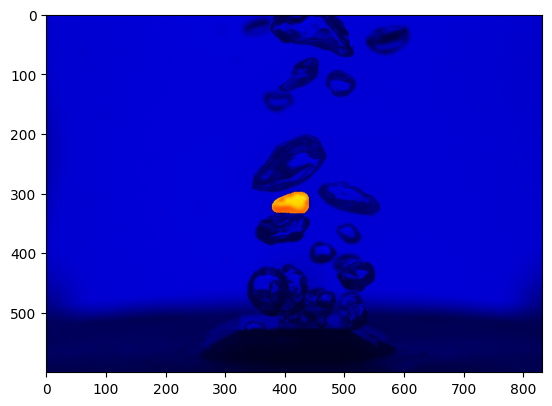

1
The predicted class is: detached


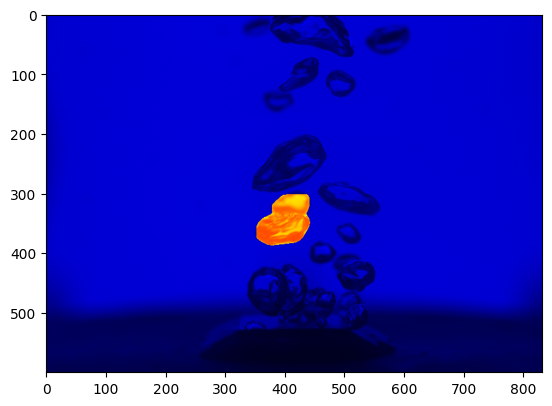

0
The predicted class is: attached


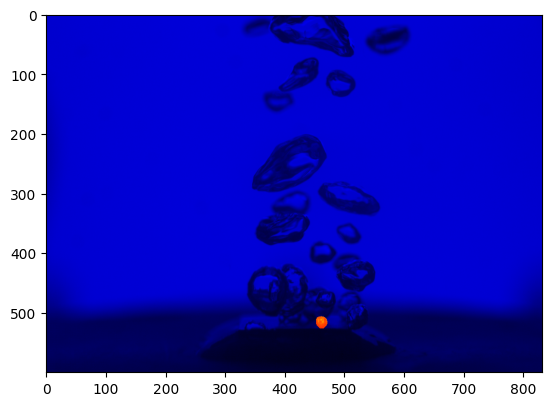

1
The predicted class is: detached


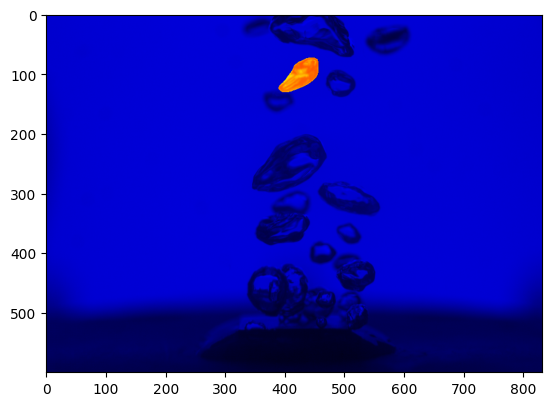

1
The predicted class is: detached


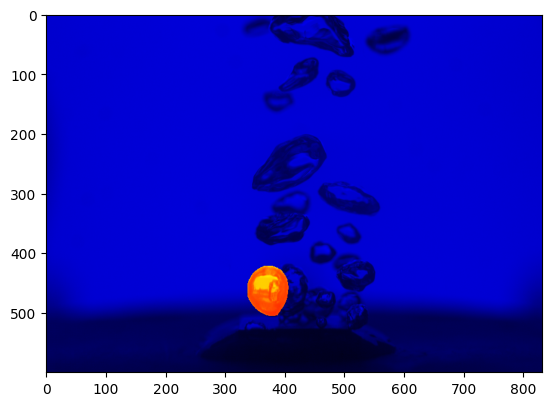

0
The predicted class is: attached


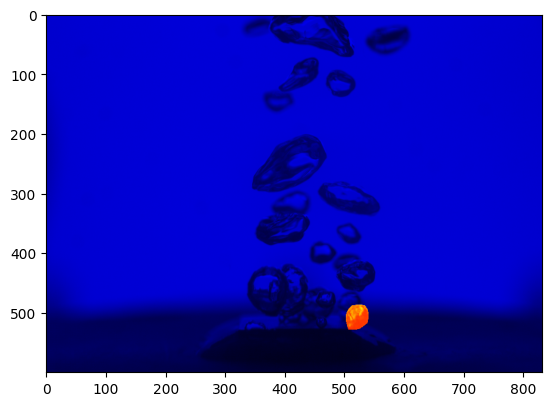

0
The predicted class is: attached


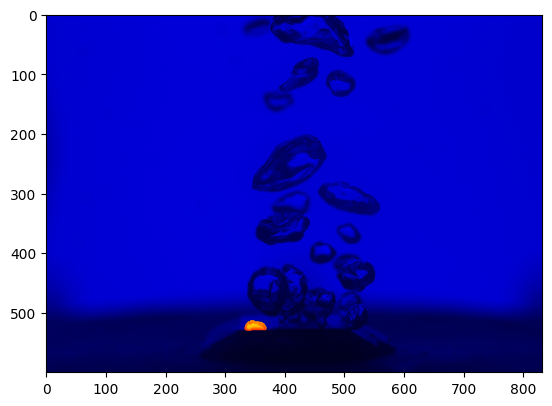

In [136]:
new_im = cv2.imread('/mnt/share/zdrive/Christy/Boiling-78/15W/Img000003.jpg')
outputs  = predictor(new_im)
new_im = cv2.cvtColor(new_im, cv2.COLOR_BGR2GRAY)
new_im = new_im.reshape((new_im.shape[0],new_im.shape[1], 1))

for i in range(len(outputs['instances'].pred_masks)):
    if outputs['instances'].scores[i] > 0.9:
        mask=outputs['instances'].pred_masks[i].cpu()
        mask=np.reshape(np.array(mask, dtype=np.uint8), (mask.shape[0], mask.shape[1],1))    

        object_image1 = np.zeros_like(new_im)
        object_image1[mask > 0] = new_im[mask > 0]

        object_image2 = np.zeros_like(new_im)
        object_image2[mask <= 0] = new_im[mask <= 0]
        
        mask = np.where(mask == 0, 0, 255).astype(np.uint8)

        combined_image = np.concatenate((mask, object_image1, object_image2), axis=2)
        mask_filename=f'./mask.png'
        cv2.imwrite(mask_filename, combined_image)
        
        input_tensor = transform(Image.open('./mask.png')).unsqueeze(0)

        model.eval()
        with torch.no_grad():
            output=model(input_tensor)

        _, predicted=torch.max(output,1)

        print(predicted.item())

        # Map the predicted class to the class name
        class_names = ['attached', 'detached']  # Make sure these class names match your training data
        predicted_class_name = class_names[predicted.item()]

        print(f'The predicted class is: {predicted_class_name}')
        plt.imshow(combined_image)
        plt.show()